# MSM of Brownian dynamics simulations of diffusion on a 1D surface
In this example we use data from a model potential in one dimension. The data is clustered by simply binning the values of the coordinate *x* and the resulting bins are used as MSM microstates.

 We start by importing the libraries needed for this example:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import itertools
import h5py
import numpy as np
from scipy.stats import norm
from scipy.stats import expon
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

#### Discretization

We load the trajectory data generated by Brownian Dynamics simulations.

In [2]:
h5file = "data/cossio_kl0_Dx1_Dq1.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

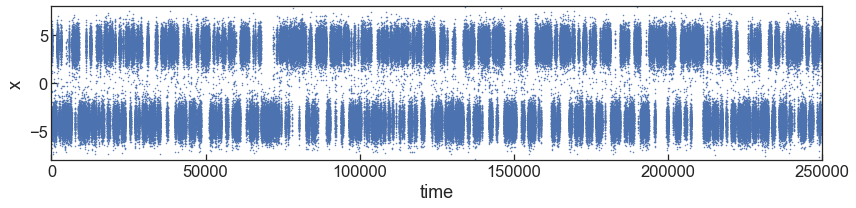

In [3]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(data[:,0],data[:,1],'.', markersize=1)
ax.set_ylim(-8,8)
ax.set_xlim(0,250000)
ax.set_ylabel('x')
ax.set_xlabel('time')
plt.tight_layout()

Clearly the system interconverts between two states. We can obtain a potential of mean force from a Boltzmann inversion of the probability distribution.

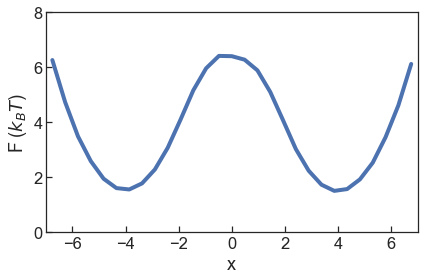

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(data[:,1], bins=np.linspace(-7,7,30),\
                               density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist), lw=4)
ax.set_xlim(-7,7)
ax.set_ylim(0,8)
ax.set_xlabel('x')
_ = ax.set_ylabel('F ($k_BT$)')
plt.tight_layout()

Instead of defining two states using an arbitrary cutoff in our single dimension, we discretize the trajectory by assigning frames to microstates. In this case we use as microstates the indexes of a grid on x.

In [5]:
assigned_trj = list(np.digitize(data[:,1],bins=bin_edges))

In this way the continuous coordinate x is mapped onto a discrete microstate space.

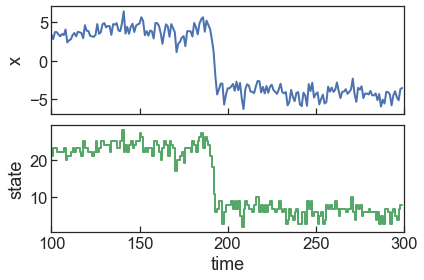

In [6]:
fig,ax=plt.subplots(2,1, sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(100,len(data[:,1][:300])),data[:,1][100:300], lw=2)
ax[1].step(range(100,len(assigned_trj[:300])),assigned_trj[100:300], color="g", lw=2)
ax[0].set_xlim(100,300)
ax[0].set_ylabel('x')
ax[1].set_ylabel("state")
ax[1].set_xlabel("time")
plt.tight_layout()

We then pass the discrete trajectory to the ``traj`` module to generate an instance of the ``TimeSeries`` class. Using some of its methods we are able to generate and sort the names of the microstates in the trajectory, which will be useful later.

In [7]:
from mastermsm.trajectory import traj
distraj = traj.TimeSeries(distraj=assigned_trj, dt=1)
distraj.find_keys()
distraj.keys.sort()

### Master Equation Model
After generating the discrete trajectory, we can build the master equation model, for which we use the ``msm`` module.

In [8]:
from mastermsm.msm import msm

First of all, we will create an instance of the SuperMSM class, which will be useful to produce and validate dynamical models.

In [9]:
msm_1D=msm.SuperMSM([distraj], sym=True)

     # states: 31


For the simplest type of dynamical model validation, we carry out a convergence test to check that the relaxation times $\tau$ do not show a dependency on the lag time. We build the MSM at different lag times $\Delta$t.

In [11]:
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_1D.do_msm(i)
    msm_1D.msms[i].do_trans(evecs=True)
    msm_1D.msms[i].boots(plot=False)

 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing


We then check the dependence of the relaxation times of the system, $\tau$ with respect to the choice of lag time $\Delta t$. We find that they are very well converged even from the shortest value of $\Delta t$.

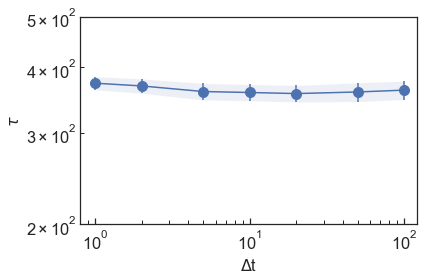

In [25]:
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[0], msm_1D.msms[x].tau_std[0]] \
               for x in sorted(msm_1D.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.fill_between(tau_vs_lagt[:,0],tau_vs_lagt[:,1]+tau_vs_lagt[:,2], \
                tau_vs_lagt[:,1]-tau_vs_lagt[:,2], alpha=0.1)
ax.set_xlabel(r'$\Delta$t', fontsize=16)
ax.set_ylabel(r'$\tau$', fontsize=16)
ax.set_xlim(0.8,120)
ax.set_ylim(2e2,500)
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

While this is not the most rigorous test we can do, it already gives some confidence on the dynamical model derived. We can inspect the count and transition matrices at even the shortest lag time

/home/daviddesancho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daviddesancho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


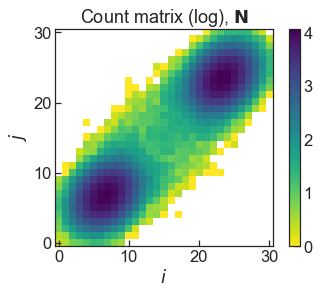

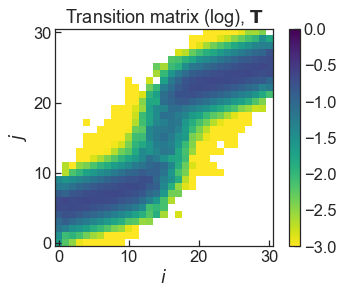

In [12]:
lt=1
plt.figure()
plt.imshow(np.log10(msm_1D.msms[lt].count), interpolation='none', \
    cmap='viridis_r', origin='lower')
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.title('Count matrix (log), $\mathbf{N}$')
plt.colorbar()
plt.savefig("../../paper/figures/1d_count.png", dpi=300, transparent=True)

plt.figure()
plt.imshow(np.log10(msm_1D.msms[lt].trans), interpolation='none', \
    cmap='viridis_r', vmin=-3, vmax=0, origin='lower')
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.title('Transition matrix (log), $\mathbf{T}$')
_ = plt.colorbar()

/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
  rvecsK_sorted[:,i] = rvecsK[:,iiK]
/home/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  lvecsK_sorted[:,i] = lvecsK[:,iiK]


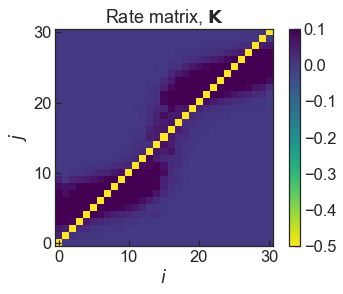

In [13]:
msm_1D.do_lbrate()
lt=1
plt.figure()
plt.imshow(msm_1D.lbrate, interpolation='none', \
    cmap='viridis_r', origin='lower', vmin=-0.5, vmax=0.1)
plt.ylabel('$\it{j}$')
plt.xlabel('$\it{i}$')
plt.title('Rate matrix, $\mathbf{K}$')
plt.colorbar()

### Analysis of the results 

The spectrum of relaxation times, $\tau_i$, derived from the eigenvalues of the transition matrix, is also remarkable. This system is expected to have a unique slow mode, corresponding to the barrier crossing process between the wells. In fact, that is precisely what we find.

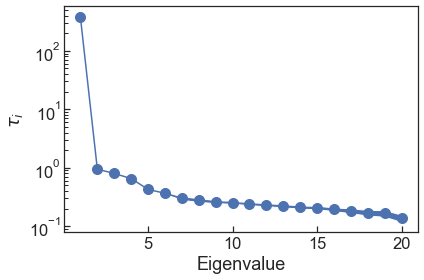

In [17]:
fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_1D.msms[1].tauT)+1),msm_1D.msms[1].tauT, fmt='o-', \
            yerr= msm_1D.msms[1].tau_std, ms=10)
ax.fill_between(range(1,len(msm_1D.msms[1].tauT)+1), \
        np.array(msm_1D.msms[1].tauT)+np.array(msm_1D.msms[1].tau_std), \
        np.array(msm_1D.msms[1].tauT)-np.array(msm_1D.msms[1].tau_std))
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$')
ax.set_yscale('log')
plt.tight_layout()

From the eigenvectors we can also retrieve valuable information. The zeroth eigenvector, $\Psi^R_0$, corresponds to the equilibrium distribution. The slowest mode in our model, captured by the first eigenvector $\Psi^R_1$, corresponds to the transition betweem the folded and unfolded states of the protein.

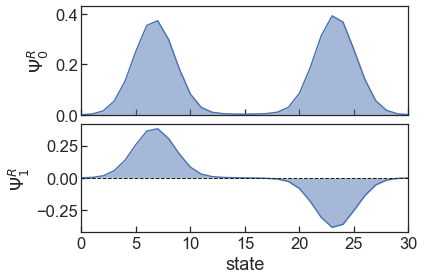

In [29]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(msm_1D.msms[1].rvecsT[:,0])
ax[0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
ax[0].set_ylim(0,0.43)

ax[1].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)
ax[1].set_xlim(0,30)

ax[1].set_xlabel("state")
ax[0].set_ylabel("$\Psi^R_0$")
ax[1].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

### Calculation of committors and reactive fluxes

In [37]:
msm_1D.msms[1].do_rate()
msm_1D.msms[1].do_pfold(FF=25, UU=5)

   definitely FF and UU states [5, 25]
   reactive flux: 0.000650102


Text(0.5, 0, 'state')

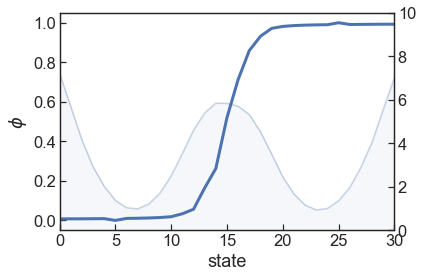

In [65]:
fig, ax = plt.subplots()

ax.set_xlim(0,30)
axalt = ax.twinx()
axalt.plot(-np.log(msm_1D.msms[1].rvecsT[:,0]), alpha=0.3, c='b')
axalt.fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   -np.log(msm_1D.msms[1].rvecsT[:,0]), 0, alpha=0.05, color='b')
axalt.set_ylim(0,10)
ax.plot(msm_1D.msms[1].pfold, lw=3)
ax.set_ylabel('$\phi$')
ax.set_xlabel('state')